### RNN, LSTM 돌려보기 2: 열 1개 데이터로, chatGPT 사용
교재 코드를 따라하니 모델이 제대로 학습하지 않아 chatGPT가 준 코드로 다시 해 봄. 하나하나 비교해보니 교재 코드를 따라할 땐 데이터를 정규화하지 않은 것이 문제였음.

In [11]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense  # RNN 모델
from tensorflow.keras.layers import LSTM  # LSTM 모델

#### 데이터 다루기

In [12]:
# 1. 데이터 불러오기
df = pd.read_csv('../AAME.csv')

# 2. Open 열만 사용
df_open = df['Open'].values.reshape(-1, 1)  # reshape: 열이 1개만 남으면 df는 2차원 형태가 풀리므로, 억지로 다시 2차원 형태를 만듦

print(df_open)

# 3. 데이터 결측치 제거, 정규화
df_open = df_open[df_open != 0.0].reshape(-1, 1)  # 0.0값은 결측치이므로 행 제거

scaler = MinMaxScaler()
df_scaled_open = scaler.fit_transform(df_open)  # 정규화

[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [2.25     ]
 [2.1099999]
 [2.1099999]]


In [13]:
# 4. 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 30  # 예: 30일 동안의 데이터를 기반으로 다음날 예측
X, y = create_sequences(df_scaled_open, sequence_length)  # 시퀀스 데이터 생성

In [14]:
# 5. 훈련/검증 데이터 분할
split = int(len(X) * 0.8)
X_test, X_train = X[:split], X[split:]
y_test, y_train = y[:split], y[split:]

#### RNN 모델

In [15]:
# 6. RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(50, activation='tanh', input_shape=(sequence_length, 1)))
model.add(Dense(1))  # 출력층

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

c:\Users\jt341\anaconda3\envs\2025AI\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# 7. 모델 학습
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0076 - mae: 0.0640 - mse: 0.0076 - val_loss: 0.0015 - val_mae: 0.0193 - val_mse: 0.0015
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9543e-04 - mae: 0.0103 - mse: 1.9543e-04 - val_loss: 0.0011 - val_mae: 0.0169 - val_mse: 0.0011
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7110e-04 - mae: 0.0096 - mse: 1.7110e-04 - val_loss: 0.0011 - val_mae: 0.0170 - val_mse: 0.0011
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5268e-04 - mae: 0.0091 - mse: 1.5268e-04 - val_loss: 9.9220e-04 - val_mae: 0.0153 - val_mse: 9.9220e-04
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3784e-04 - mae: 0.0086 - mse: 1.3784e-04 - val_loss: 9.3113e-04 - val_mae: 0.0148 - val_mse: 9.3113e-04
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3648e-04 - mae: 0.0086 - mse: 1.3648e-04 - val_loss: 9.2151e-04 - val_mae: 0.0144 - val_mse: 9.2151e-04
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

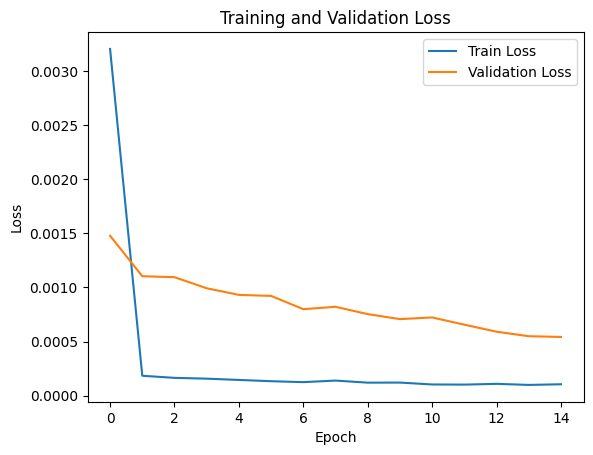

In [17]:
# 8. 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


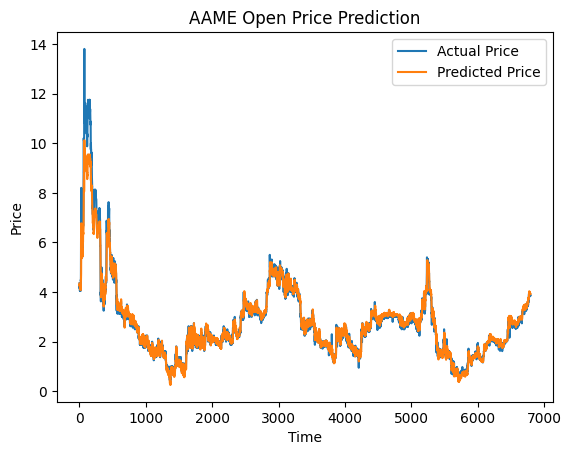

In [18]:
# 9. 예측 및 역정규화
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# 10. 예측 결과 시각화
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.legend()
plt.title('AAME Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

#### LSTM 모델

In [22]:
# 6-2. LSTM 모델 정의
model2 = Sequential()
model2.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, 1)))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

c:\Users\jt341\anaconda3\envs\2025AI\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# 7. 모델 학습
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0221 - mae: 0.1111 - mse: 0.0221 - val_loss: 0.0044 - val_mae: 0.0476 - val_mse: 0.0044
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5059e-04 - mae: 0.0207 - mse: 6.5059e-04 - val_loss: 0.0019 - val_mae: 0.0327 - val_mse: 0.0019
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3674e-04 - mae: 0.0140 - mse: 3.3674e-04 - val_loss: 5.1457e-04 - val_mae: 0.0146 - val_mse: 5.1457e-04
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7323e-04 - mae: 0.0095 - mse: 1.7323e-04 - val_loss: 4.7782e-04 - val_mae: 0.0127 - val_mse: 4.7782e-04
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8052e-04 - mae: 0.0095 - mse: 1.8052e-04 - val_loss: 4.8563e-04 - val_mae: 0.0125 - val_mse: 4.8563e-04
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5670e-04 - mae: 0.0090 - mse: 1.5670e-04 - val_loss: 5.4062e-04 - val_mae: 0.0144 - val_mse: 5.4062e-04
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━

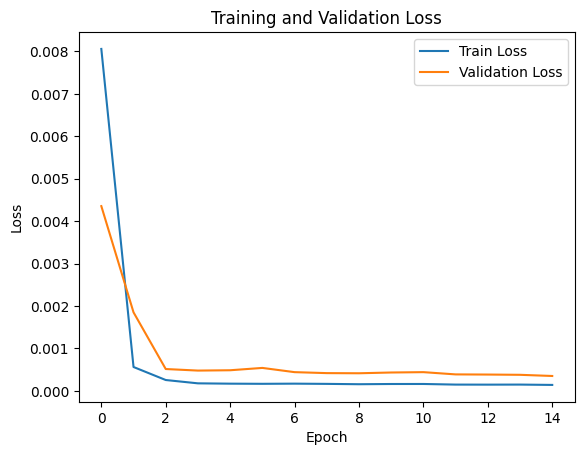

In [24]:
# 8. 결과 시각화
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


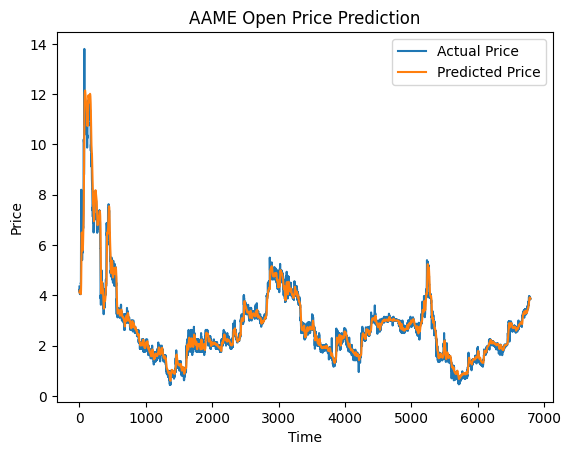

In [26]:
# 9. 예측 및 역정규화
predicted = model2.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# 10. 예측 결과 시각화
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.legend()
plt.title('AAME Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()